In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
data = pd.read_csv('./data/classification_cas_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
data.drop('sequence', inplace=True,axis=1)
def str_to_list(string):
    return [int(s) for s in string[1:-1].split(',')]
data['channels'] = data['channels'].apply(str_to_list)

In [ ]:
data.head()

,Mass/Time,MassOffset,file_name,StartFlightTime,SpecBinSize,channels
0,0.380687,-0.303627,0909402.cas,0.000,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.172033,-0.521234,NYLN6603.cas,7.140,1.250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.387569,-0.280513,1229201.cas,0.000,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.379172,-0.000047,CHB86ND.cas,0.000,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.170166,-0.511654,D1_01.cas,7.147,1.250,"[1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, ..."


In [ ]:
err_data = data.copy()

In [ ]:
def add_error(number):
    '''
    Add or subtract a random amount of error between .5% and 1%.
    '''
    randoms = np.random.rand(2)
    error = (1 - randoms[0] / 2) / 100
    new_num = 0
    if randoms[1] < .5:
        new_num  = number - number * error
        error = error * -1
    else:
        new_num = number + number * error
    return new_num, error

In [ ]:
def generate_data(err_data):
    '''
    Takes calibrated ToF-MS data and adds a 1%-.5% error to 
    the Mass/Time and MassOffset values in 50% of rows. Returns
    changed data frame with new column rerpresenting which
    rows have changed values.
    '''
    target = []
    error_percent_slope = []
    error_percent_offset = []
    new_slope = []
    new_offset = []
    for row in err_data.iterrows():
        if np.random.rand(1) < 0.5:
            target.append(0)
            slope, sl_err = add_error(row[1]['Mass/Time'])
            offset, off_err = add_error(row[1]['MassOffset'])
            error_percent_slope.append(sl_err)
            error_percent_offset.append(off_err)
            new_slope.append(slope)
            new_offset.append(offset)
        else:
            target.append(1)
            error_percent_slope.append(0)
            error_percent_offset.append(0)
            new_slope.append(row[1]['Mass/Time'])
            new_offset.append(row[1]['MassOffset'])
    err_data['target'] = target
    err_data['err_prop_slope'] = error_percent_slope
    err_data['err_prop_offset'] = error_percent_offset
    err_data['Mass/Time'] = new_slope
    err_data['MassOffset'] = new_offset

In [ ]:
generate_data(err_data)

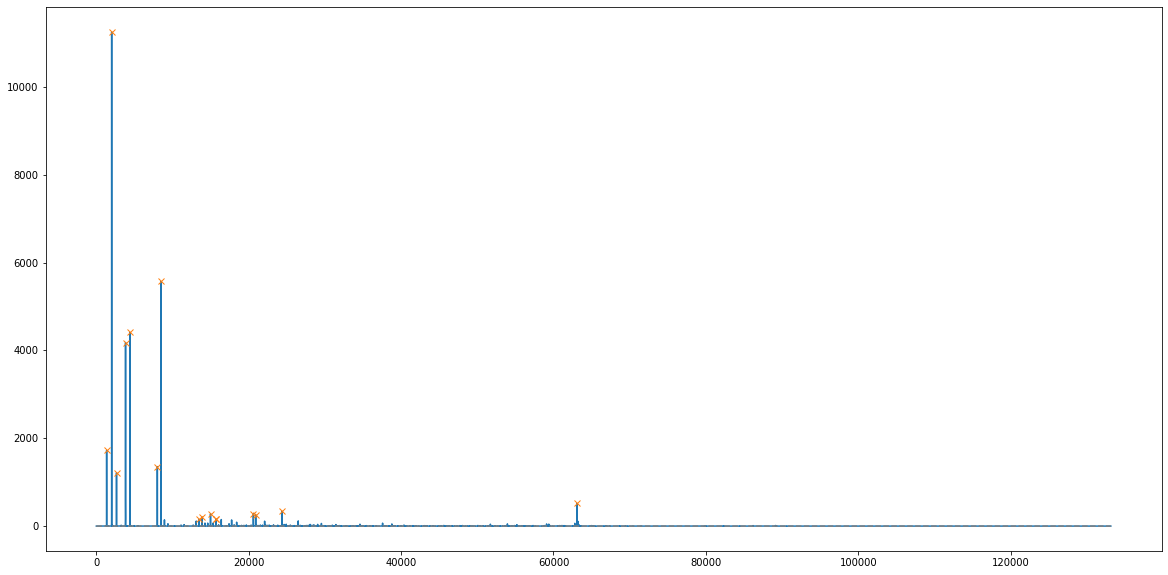

In [ ]:
from scipy.signal import find_peaks
x = np.array(err_data['channels'][305])
peaks, _ = find_peaks(x, height=150)
plt.figure(figsize = (20, 10))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [ ]:
def get_peaks(channels, height=50):
    '''
    Takes peaks for spectrum and returns all peaks and
    channel locations above given height, default height is 100.
    '''
    peak_loc, heights = find_peaks(channels, height=height)
    return list(zip(peak_loc, heights['peak_heights'].astype(int)))

In [ ]:
err_data['channel, peak'] = err_data['channels'].apply(get_peaks)

In [ ]:
def get_min_peaks():
    '''
    Determine the smallest number of peaks the database has.
    '''
    min_peaks = len(err_data['channel, peak'][0])
    for tups in err_data['channel, peak']:
        if min_peaks > len(tups) :
            min_peaks = len(tups)
    return min_peaks

In [ ]:
get_min_peaks()

6

In [ ]:
err_data['peak_num'] = err_data['channel, peak'].apply(len)
err_data2 = err_data[err_data['peak_num'] >= 20].copy()
#err_data2.reset_index(inplace=True, drop=True)

In [ ]:
def get_best_peaks(nbest):
    '''
    Return list of the n best or most spread out peaks for each data point.
    '''
    results = []
    for tups in err_data2['channel, peak']:
        best_peaks = []
        def loc(a):
            return a[0]
        
        tups.sort(key=loc)
        tups = np.array(tups)
        best_peaks.append(tups[0])
        best_peaks.append(tups[-1])
        indices = np.random.choice(np.array(range(len(tups[1:-1]))), nbest - 2)
        for index in indices:
            best_peaks.append(tups[index])
    
        results.append(best_peaks)
    return results

In [ ]:
results = get_best_peaks(20)

In [ ]:
err_data2['best_peaks'] = results

In [ ]:
def mass_formula(channel, spec_bin_size,start_time,  mass_over_time, mass_offset):
        '''
        Apply formula for calculating mass at a channel.
        '''
        return ((channel * .001 * spec_bin_size + start_time) * mass_over_time + mass_offset)**2

In [ ]:
def generate_calibrated_data():
    '''
    Applies mass_formula to every row in dataset to allow
    calibrated graphs to be generated.
    '''
    masses = []
    channels = []
    intensities = []
    for row in err_data2.iterrows():
        mass = []
        channel = []
        intensity = []
        spec = row[1]['SpecBinSize']
        m_over_t = row[1]['Mass/Time']
        m_offset = row[1]['MassOffset']
        time = row[1]['StartFlightTime']
        for tup in row[1]['best_peaks']:
            mass.append(mass_formula(tup[0], spec, time, m_over_t, m_offset))
            channel.append(tup[0])
            intensity.append(tup[1])
        intensities.append(intensity)   
        masses.append(mass)
        channels.append(channel)
    return masses, channels, intensities

In [ ]:
masses, channels, intensities = generate_calibrated_data()

In [ ]:
points = []
spec = err_data['SpecBinSize'][305]
m_over_t = err_data['Mass/Time'][305]
m_offset = err_data['MassOffset'][305]
time = err_data['StartFlightTime'][305]
for num in range(len(err_data['channels'][305])):
    points.append(mass_formula(num, spec, time, m_over_t, m_offset))

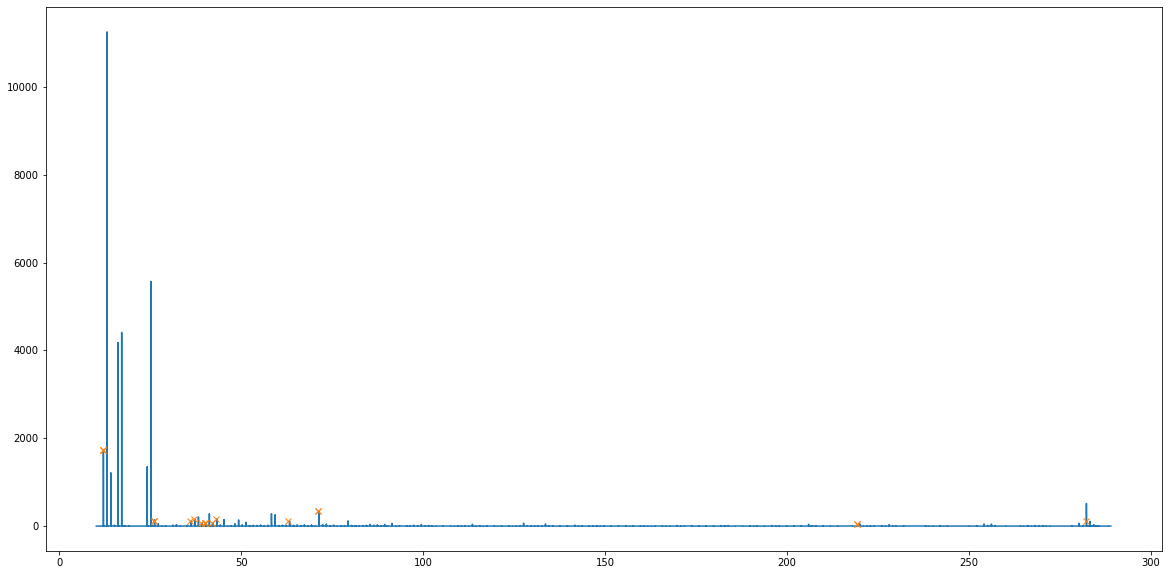

In [ ]:
x = np.array(points[0:64000])
y = np.array(err_data2['channels'][305][0:64000])
plt.figure(figsize = (20, 10))
plt.plot(x, y)
plt.plot(masses[302], y[channels[302]], "x")

In [ ]:
err_data2['best_peak_masses'] = masses
err_data2['best_peak_intensity'] = intensities
err_data2['best_peak_channel'] = channels

In [ ]:
training_data = err_data2[err_data2['peak_num'] >= 20].copy()
training_data = training_data[['target', 'best_peak_masses', 'best_peak_intensity', 'best_peak_channel', 'MassOffset', 'Mass/Time']].copy()

In [ ]:
training_data.head()

,target,best_peak_masses,best_peak_intensity,best_peak_channel,MassOffset,Mass/Time
0,1,"[11.716806862006623, 40.14533302334786, 16.620...","[6046, 63, 8697, 728, 52, 20831, 8697, 1795, 5...","[7929, 14122, 9319, 10955, 14112, 9056, 9319, ...",-0.306647,0.376906
1,1,"[1.0076952446290026, 453.33686875444766, 154.0...","[5053, 57, 51, 513, 88, 2971, 272, 296, 50, 15...","[1380, 95724, 54435, 26134, 45728, 31527, 3883...",-0.521234,0.172033
2,0,"[0.9942303634062117, 279.4670523436271, 132.30...","[1502, 53, 71, 51, 81, 280, 80, 338, 81, 2032,...","[2643, 35281, 24454, 18403, 14442, 25668, 1775...",-0.275895,0.385939
3,0,"[1.0016014552204566, 216.43761759556722, 129.2...","[3331, 62, 78, 152, 1563, 832, 80, 381, 153, 1...","[19188, 282052, 217972, 171902, 108062, 145549...",-0.000048,0.377972
4,1,"[0.9761933219100396, 614.9237963220239, 42.314...","[2563, 52, 447, 1456, 95, 549, 168, 74, 61, 23...","[1407, 114207, 27544, 30570, 27707, 39008, 453...",-0.515823,0.168863


In [ ]:
len(training_data['best_peak_channel'][0])

20

In [ ]:
mass_names = ['peak_mass' + str(x) for x in range(20)]
channel_names = ['peak_channel' + str(x) for x in range(20)]
intensity_names = ['peak_intensity' + str(x) for x in range(20)]

In [ ]:
training_data[mass_names] = pd.DataFrame(training_data.best_peak_masses.tolist(), index= training_data.index)
#training_data[channel_names] = pd.DataFrame(training_data.best_peak_channel.tolist(), index= training_data.index)
#training_data[intensity] = pd.DataFrame(training_data.best_peak_intensity.tolist(), index= training_data.index)
training_data.drop(['best_peak_masses', 'best_peak_intensity', 'best_peak_channel'], axis=1, inplace=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
from sklearn.metrics import accuracy_score
def model_acc(model, X_test, y_test):
    preds = model.predict(X_test)
    return(accuracy_score(y_test, preds), preds)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
def kfold(X, y, k=5, stratify=False, shuffle=True, seed=33):
        """K-Folds cross validation iterator.

        Parameters
        ----------
        k : int, default 5
        stratify : bool, default False
        shuffle : bool, default True
        seed : int, default 33

        Yields
        -------
        X_train, y_train, X_test, y_test, train_index, test_index
        """
        if stratify:
            kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=shuffle)
        else:
            kf = KFold(n_splits=k, random_state=seed, shuffle=shuffle)
        
        data = np.array(X)
        target = np.array(y)
        for train_index, test_index in kf.split(X, y):
            X_train, y_train = data[train_index], target[train_index]
            X_test, y_test = data[test_index], target[test_index]
            yield X_train, y_train, X_test, y_test, train_index, test_index

In [ ]:
def get_kfold_stats(X, y, nsplits, seed=33, models=None):
    '''
	Train models on X, y using kfold cross validation with nsplits. Models 
	defaults to XGBoost, LightGB, and RandomForestClassifier.
	Returns average accuracy of each model and the incorrect predictions
	and indexes of each incorrectly predicted point.

	Arguments -----
	X features / training variables
	y target / training labels
	nsplits (optional) default: 5 number of splits to use in kfold algorithm
	models (optional) list of ml models to train
	'''
    if not models:
        models = [XGBClassifier(), LGBMClassifier(), RandomForestClassifier(n_estimators=100, max_depth=None)]
    xlr_accs = [0 for model in models]
    xlr_index_pred = [[] for model in models]
    avg_feature_importance = [np.zeros(X.shape) for model in models]
    for X_train, y_train, X_test, y_test, train_index, test_index in kfold(X, y, nsplits, seed=seed):
        for model in models:
            model.fit(X_train, y_train)
            
        for i, model in enumerate(models):
            acc, preds = model_acc(model, X_test, y_test)
            xlr_accs[i] += acc / nsplits
            xlr_index_pred[i] += zip(test_index, preds)
        avg_feature_importance[i] += model.feature_importances_
            
    return xlr_accs, xlr_index_pred, [x / nsplits for x in avg_feature_importance]

In [ ]:
def get_pred_data(preds, names = ['xgb', 'lgbm', 'rfc']):
    '''
    Using output of get_wrong_preds, gets dataframe representing how
    models performed on the examples which were incorrectly classified.
    '''
    def loc(tup):
        return tup[0]
    pred_data = err_data2.copy()
    for num in range(len(names)):
        preds[num].sort(key=loc)
        pred_data[names[num]] = np.array(preds[num])[:, 1]
    return pred_data

In [ ]:
def get_distance_from_int(num):
    return abs(num - round(num))
for name in mass_names:
    training_data[name + 'd_from_int'] = training_data[name].apply(get_distance_from_int)

In [ ]:
training_data

,target,MassOffset,Mass/Time,peak_mass0,peak_mass1,peak_mass2,peak_mass3,peak_mass4,peak_mass5,peak_mass6,...,peak_mass10d_from_int,peak_mass11d_from_int,peak_mass12d_from_int,peak_mass13d_from_int,peak_mass14d_from_int,peak_mass15d_from_int,peak_mass16d_from_int,peak_mass17d_from_int,peak_mass18d_from_int,peak_mass19d_from_int
0,0,-0.306344,0.377813,11.780445,40.352119,15.710584,30.461261,36.341653,17.674696,25.588484,...,0.421167,0.290993,0.417050,0.411516,0.373638,0.221795,0.417050,0.497087,0.341653,0.253462
1,0,-0.516841,0.170380,0.987197,444.640331,49.049304,30.417995,130.347955,110.929438,75.550639,...,0.301844,0.360203,0.424427,0.268112,0.114992,0.123956,0.066337,0.163633,0.355343,0.114992
2,1,-0.280513,0.387569,0.995741,281.716144,75.195636,133.379122,148.416136,11.970413,131.287024,...,0.011672,0.018395,0.039626,0.283651,0.008436,0.013297,0.002424,0.379122,0.029587,0.007262
3,1,-0.000047,0.379172,1.007972,217.813960,164.883062,123.897774,126.908390,155.100640,124.908603,...,0.180038,0.098033,0.009811,0.019442,0.124131,0.204636,0.008922,0.095426,0.184651,0.110110
4,1,-0.511654,0.170166,1.007620,624.861064,42.335177,82.073915,30.042298,27.074220,69.280606,...,0.052549,0.270328,0.086114,0.085719,0.159248,0.023546,0.064578,0.031741,0.413265,0.014358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,0,-0.000056,0.377120,1.991586,420.600041,296.844440,125.644907,127.678472,11.864862,28.677413,...,0.251773,0.134759,0.132056,0.051416,0.276122,0.124388,0.123804,0.145787,0.149798,0.202782
902,0,-0.274136,0.384347,1.015114,284.242534,16.174414,82.957653,142.702298,143.666558,3.042560,...,0.182261,0.026229,0.311979,0.410499,0.038370,0.296176,0.242879,0.483265,0.213973,0.152098
903,0,-0.000041,0.378890,1.019223,468.476047,69.754126,139.507943,47.539209,30.344533,58.769880,...,0.352744,0.414326,0.278010,0.117396,0.316641,0.299151,0.239112,0.123873,0.224390,0.110453
904,1,-0.000036,0.378123,11.987359,514.960639,113.038235,344.985521,184.982672,146.986490,93.984587,...,0.018137,0.050685,0.027516,0.016263,0.042383,0.047736,0.016856,0.042766,0.012641,0.041343


In [ ]:
X = training_data.drop(['target'], axis = 1)
y = training_data['target']

In [ ]:
# XGBCLassifier parameters
learning_rate = [0.4, .5, 0.3] # default 0.3
max_depth = [2,3,4] # default 6 
min_child_weight = [1] # default 1

In [ ]:
params2 = []
accs2 = []
for lr in learning_rate:
    for depth in max_depth:
        for mcw in min_child_weight:
            acc_seed = 0
            for seed in np.random.randint(1, 100, size=15):
                model = XGBClassifier(max_depth=depth, learning_rate=lr, min_child_weight=mcw)
                acc, _, p = get_kfold_stats(X, y, 5, 33, models=[model])
                acc_seed += acc[0] / 15
            accs2.append(acc_seed)
            params2.append([lr, depth, mcw])

In [ ]:
def test_lgbm(lrs, n_leav, n_ests, m_depths, boost_type, seed_num):
    accs = []
    params = []
    for num in n_leav:
        for lr in lrs:
            for n_est in n_ests:
                for depth in m_depths:
                    for boost in boost_type:
                        seed_acc = 0
                        for seed in np.random.randint(1, 100, size=seed_num):
                            model = LGBMClassifier(boosting_type=boost,max_depth=depth,
                                                   num_leaves=num, learning_rate=lr,
                                                   n_estimators=n_est)
                            acc, _, p = get_kfold_stats(X, y, 5, seed_num, models=[model])
                            seed_acc += acc[0] / 15
                        accs.append(seed_acc)
                        params.append([boost, lr, num, n_est, depth,])
    best_acc = max(accs)
    best_params = params[accs.index(max(accs))]
    return (accs, params, best_acc, best_params)

In [ ]:
# LGBMClassifier parameters
learning_rate = [.3, .4, .5] # default 0.1
num_leaves = [7, 8]
n_estimators = [75] # default 100
max_depth = [2, 3, 5]

In [ ]:
accs, params, best_acc, best_params = test_lgbm(learning_rate, num_leaves, n_estimators, max_depth, ['goss'], 15)

In [ ]:
print(best_acc)
print(best_params)

0.9831962839746405
['goss', 0.5, 8, 75, 5]


In [ ]:
accs, good_preds, importancez = get_kfold_stats(X, y, 5, 504, models=[LGBMClassifier(boosting_type='goss',
                                                                                     max_depth=3, learning_rate=.45,
                                                                                     n_estimators=64, num_leaves=7)])
print(accs)
pred_data = get_pred_data(good_preds, names=['lgbm'])
wrong = pred_data[pred_data['target'] != pred_data['lgbm']]

[0.9753625007846338]


In [ ]:
wrong.describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,peak_num,lgbm
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.318185,-0.417965,3.205092,2.148409,0.545455,-0.000602,0.000050,765.954545,0.454545
std,0.104240,0.389840,5.189057,3.352061,0.509647,0.004031,0.005837,675.624401,0.509647
min,0.170328,-1.192378,0.000000,0.138000,0.000000,-0.007768,-0.009926,92.000000,0.000000
25%,0.172192,-0.521968,0.000000,0.172500,0.000000,-0.003774,0.000000,185.500000,0.000000
50%,0.378003,-0.440167,0.000000,0.936500,1.000000,0.000000,0.000000,448.500000,0.000000
75%,0.382642,-0.000054,6.104000,1.250000,1.000000,0.000000,0.000000,1311.250000,1.000000
max,0.465061,0.000056,16.097000,10.000000,1.000000,0.006130,0.009289,2191.000000,1.000000


In [ ]:
err_data2.describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,peak_num
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,0.319960,-0.229299,3.118891,1.201657,0.528555,-0.000029,0.000240,472.120941
std,0.094774,0.293782,5.324463,2.424477,0.499464,0.005310,0.005254,721.026112
min,0.167500,-1.201129,-0.929000,0.138000,0.000000,-0.009997,-0.009982,21.000000
25%,0.172932,-0.511911,0.000000,0.138000,0.000000,0.000000,0.000000,127.000000
50%,0.377204,-0.000200,0.000000,0.138000,1.000000,0.000000,0.000000,262.000000
75%,0.380507,-0.000017,7.086000,1.250000,1.000000,0.000000,0.005037,575.000000
max,0.465998,0.001724,21.571000,20.000000,1.000000,0.009998,0.009986,10384.000000


### Optimal Parameters

#### XGBoost

 + Learning rate 0.5
 + max depth 3
 + min child wieght 1
 
#### LGBM
 
 + booster goss
 + num leaves 7
 + depth 3
 + n_estimators 64
 + learning rate 0.45